# Heavy-tailed Markov Chain Tutorial

This notebook demonstrates the knockoff construction for the heavy-tailed Markov Chain where each variable has t-distributed tails. The model is as follows:
$$X_1=\sqrt{\frac{\nu-2}\nu}Z_1, \quad X_{j+1}=\rho_j X_j + \sqrt{1-\rho_j^2}\sqrt{\frac{\nu-2}\nu}Z_{j+1}, \quad Z_j\stackrel{i.i.d.}{\sim} t_\nu$$
for $j=1,\dots,p$.  Section 5.2.1 of the accompanying paper presents a large set of simulation results in this setting.

## Multiple-try Metropolis

We demonstrate the Multiple-try Metropolis (Section 3.3 of the paper) proposals below.

In [1]:
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

%run ../heavy-tailed-t/t_core #load the functions for the t-MC experiment

In [2]:
#simulation parameters
df_t = 5 # degree of freedom of t-distribution
p = 30 # dimension of the random vector X
numsamples = 200 # number of samples to generate knockoffs 
rhos = [0.6] * (p-1) # the correlations

#algorithm parameters
halfnumtry = 1 # m/half number of candidates
stepsize = 1.5 # step size in the unit of 1/\sqrt((\Sigma)^{-1}_{jj})

We first compute the proposal scaling for each variable. Recall that the recommended scaling for the proposal for variable $j$ is $1.5 / \sqrt{(\Sigma^{-1})_{jj}}$ (Section 3.3 of the paper).

In [3]:
#generate the proposal grid
quantile_x = np.zeros([p, 2*halfnumtry + 1])
sds = [0]*p
sds[0] = math.sqrt(1 - rhos[0]**2)
for i in range(1,p - 1):
    sds[i] = math.sqrt((1 - rhos[i - 1]**2)*(1 - rhos[i]**2) /
                       (1 - rhos[i - 1]**2*rhos[i]**2))
sds[p - 1] = math.sqrt(1 - rhos[p - 2]**2)
for i in range(p):
    quantile_x[i] = [x*sds[i]*stepsize for x in list(
        range(-halfnumtry, halfnumtry + 1))]

Next, we sample observations from the Markov Chain and generate knockoffs with the MTM technique using the `SCEP_MH_MC` function.

In [4]:
bigmatrix = np.zeros([numsamples, 2*p]) # store simulation data

#generate each observation and knockoff
start = time.time()
for i in range(numsamples):
    #sample one instance from the Markov Chain
    bigmatrix[i, 0] = t.rvs(df=df_t)*math.sqrt((df_t - 2)/df_t)
    for j in range(1, p):
        bigmatrix[i, j] = math.sqrt(1 - rhos[j - 1]**2)*t.rvs(df=df_t)* \
        math.sqrt((df_t - 2)/df_t) + rhos[j - 1]*bigmatrix[i,j - 1]
    
    #sample the knockoff for the observation
    bigmatrix[i, p:(2*p)] = SCEP_MH_MC(bigmatrix[i, 0:p], 0.999, 
                                       quantile_x, rhos, df_t)
end = time.time()

print("Average time per observation + knockoff (seconds): " + \
      '%.3f'%((end - start) / numsamples))

np.shape(bigmatrix)

Average time per observation + knockoff (seconds): 0.349


(200, 60)

#### Knockoff quality

We can compute the mean correlation between $X_j$ and $\tilde{X}_j$ to measure the knockoff quality:

In [5]:
cors = []
for j in range(p):
    cors += [np.corrcoef(bigmatrix[:, j], bigmatrix[:, j + p])[0, 1]]
np.mean(cors)                    

0.6682619712269171

We can also plot the correlation between $X_j$ and $\tilde{X}_j$ across different coordinates:

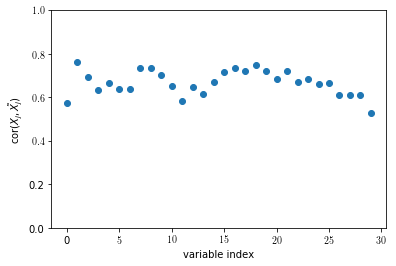

In [6]:
plt.scatter(range(p), cors)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylim(0,1)
plt.ylabel(r"cor$(X_j, \tilde{X_j})$")
plt.xlabel("variable index")
plt.show()

We see that the first and last knockoff have higher quality, since these variables only depend on one other variable.

#### Diagnostics: checking means and covariances

As a basic diagnostic, we check that each coordinate is mean zero and the the empirical covariance matrices of $X$ and $\tilde{X}$ are close. As the number of samples increases, the empirical covariance of $X$ and $\tilde{X}$ will converge to the same population covariance.

In [7]:
#largest mean of the columns of X
print(np.max(np.abs(np.mean(bigmatrix[:, 0:p], axis = 0))))
#largest mean of the columns of Xk
print(np.max(np.abs(np.mean(bigmatrix[:, p:(2*p)], axis = 0))))

0.13386621056268866
0.12291280708251455


We can visualize the difference in the empirical covariance matrices of $X$ and $\tilde{X}$ with a heatmap.

In [8]:
#empirical correlation matrices
S = np.corrcoef(bigmatrix[:, 0:p].T)
Sk = np.corrcoef(bigmatrix[:, p:(2*p)].T)

#largest difference in population correlation
np.max(np.abs(S - Sk))

0.22905483366754087

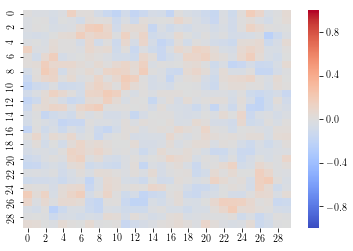

In [9]:
S = np.corrcoef(bigmatrix[:, 0:p].T)
Sk = np.corrcoef(bigmatrix[:, p:(2*p)].T)
ax = sns.heatmap(S - Sk, vmin = -1, vmax = 1, cmap="coolwarm")

We see that the difference in the empirical correlation matrix of $X$ and the empirical correlation matrix of $\tilde{X}$ are small, as expected, since $X$ and $\tilde{X}$ come from the same distribution.

## Covariance-guided proposals

We can also generate knockoffs with the covariance-guided proposals (Section 3.2 of the paper) with the `SCEP_MH_COV` function. These proposals are motivated by a Gaussian approximation (indeed, they are optimal for Gaussian distributions), but they produce *exact* knockoffs because of the Metropolis--Hastings correction.

In [10]:
# solve the sdp to find the 
# optimal proposal parameters
param_list = compute_proposals(rhos) 

     pcost       dcost       gap    pres   dres   k/t
 0: -3.0000e+01 -1.5000e+02  3e+02  9e-01  1e+00  1e+00
 1: -2.4222e+01 -4.8476e+01  3e+01  2e-01  3e-01  4e-01
 2: -2.1826e+01 -4.4226e+01  3e+01  2e-01  3e-01  4e-01
 3: -1.5998e+01 -1.9659e+01  5e+00  3e-02  4e-02  7e-02
 4: -1.5878e+01 -1.6094e+01  3e-01  2e-03  2e-03  4e-03
 5: -1.5835e+01 -1.5916e+01  1e-01  6e-04  9e-04  2e-03
 6: -1.5814e+01 -1.5819e+01  6e-03  4e-05  6e-05  1e-04
 7: -1.5813e+01 -1.5813e+01  4e-04  2e-06  3e-06  6e-06
 8: -1.5813e+01 -1.5813e+01  1e-04  6e-07  1e-06  1e-06
 9: -1.5813e+01 -1.5813e+01  2e-06  1e-08  2e-08  3e-08
Optimal solution found.
0.4729166501155528


In [11]:
bigmatrix_cov = bigmatrix.copy() #use the samples from MTM

#generate the covariance-guided knockoffs
start = time.time()
for i in range(numsamples):   
    #generate a knockoff for the observation
    bigmatrix_cov[i, p:(2*p)] = SCEP_MH_COV(bigmatrix_cov[i, 0:p], 0.999, 
                                       np.zeros(p), df_t, rhos, param_list)
end = time.time()

print("Average time per observation + knockoff (seconds): " + \
      '%.3f'%((end - start) / numsamples))    
    
np.shape(bigmatrix_cov)

Average time per observation + knockoff (seconds): 0.045


(200, 60)

#### Knockoff quality

We can compute the mean correlation between $X_j$ and $\tilde{X}_j$ to measure the knockoff quality:

In [12]:
cors = []
for j in range(p):
    cors += [np.corrcoef(bigmatrix_cov[:, j], bigmatrix_cov[:, j + p])[0, 1]]
np.mean(cors)                    

0.6272916434707655

We can also plot the correlation between $X_j$ and $\tilde{X}_j$ across different coordinates:

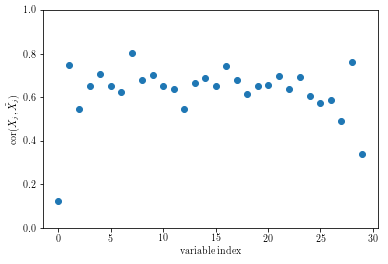

In [13]:
plt.scatter(range(p), cors)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylim(0,1)
plt.ylabel(r"cor$(X_j, \tilde{X_j})$")
plt.xlabel("variable index")
plt.show()

We see that the first and last knockoff have higher quality, since these variables only depend on one other variable.

#### Diagnostics: checking means and covariances

As a basic diagnostic, we check that each coordinate is mean zero and the the empirical covariance matrices of $X$ and $\tilde{X}$ are close. As the number of samples increases, the empirical covariance of $X$ and $\tilde{X}$ will converge to the same population covariance.

In [14]:
#largest mean of the columns of X
print(np.max(np.abs(np.mean(bigmatrix_cov[:, 0:p], axis = 0))))
#largest mean of the columns of Xk
print(np.max(np.abs(np.mean(bigmatrix_cov[:, p:(2*p)], axis = 0))))

0.13386621056268866
0.14545874577966963


We can visualize the difference in the empirical covariance matrices of $X$ and $\tilde{X}$ with a heatmap.

In [15]:
#empirical correlation matrices
S = np.corrcoef(bigmatrix_cov[:, 0:p].T)
Sk = np.corrcoef(bigmatrix_cov[:, p:(2*p)].T)

#largest difference in population correlation
np.max(np.abs(S - Sk))

0.2244188283867856

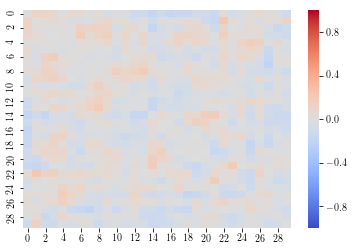

In [16]:
S = np.corrcoef(bigmatrix_cov[:, 0:p].T)
Sk = np.corrcoef(bigmatrix_cov[:, p:(2*p)].T)
ax = sns.heatmap(S - Sk, vmin = -1, vmax = 1, cmap="coolwarm")

We see that the difference in the empirical correlation matrix of $X$ and the empirical correlation matrix of $\tilde{X}$ are small, as expected, since $X$ and $\tilde{X}$ come from the same distribution.